### Image analysis with PlantCV Application

Analyze Teff Images


In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
from plantcv import plantcv as pcv

In [2]:
# Print the PlantCV version
pcv.__version__

'3.12.1'

In [38]:
# Handle input variables
# This code was provided to make it easier to convert the notebook to a script
class options():
    def __init__(self):
        self.debug   = "plot"
        self.result   = "results.csv"
        self.outdir   = "./output_images"
        self.writeimg = True
        self.image = "/shares/mgehan_share/mgehan/getu-tef/images/experiment1/e1-teff-03-22-2021/8660-6-84-Tray1-1.JPG"
#         self.image = "/shares/mgehan_share/mgehan/getu-tef/images/experiment2/e2-teff-05172021/8660-12-75-Tray3-1-05172021.JPG"

In [39]:
# Create input arguments object
args = options()

In [40]:
# Set debug mode and debug outdir
pcv.params.debug        = args.debug
pcv.params.debug_outdir = args.outdir

In [41]:
# Create a folder to save the result image files if the folder not exists
if not os.path.exists(args.outdir):
    os.makedirs(args.outdir)

In [42]:
# Update params related to plotting so we can see better 
pcv.params.text_size=50
pcv.params.text_thickness=15
pcv.params.dpi = 150

#### STEP 1: Open an image
We start with a top view of the plants

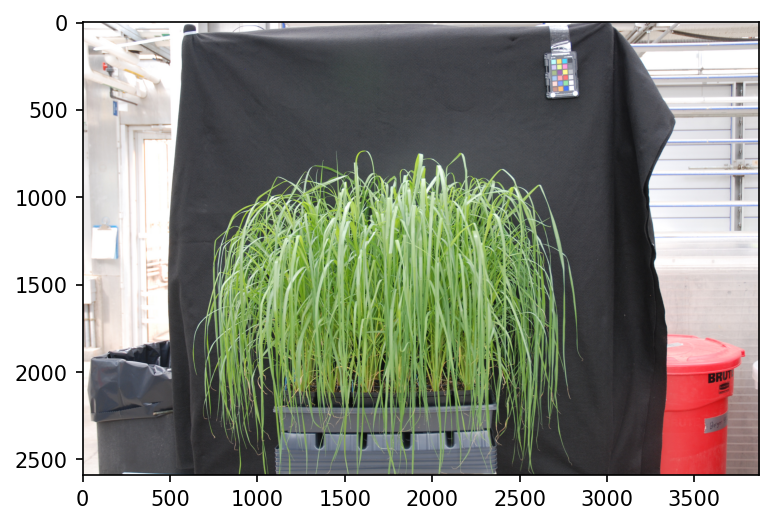

In [43]:
img, imgpath, imgname = pcv.readimage(filename=args.image)

#### STEP 2: Find the color card and correct the exposure of the image
The color card can be find automatically or defined location manually

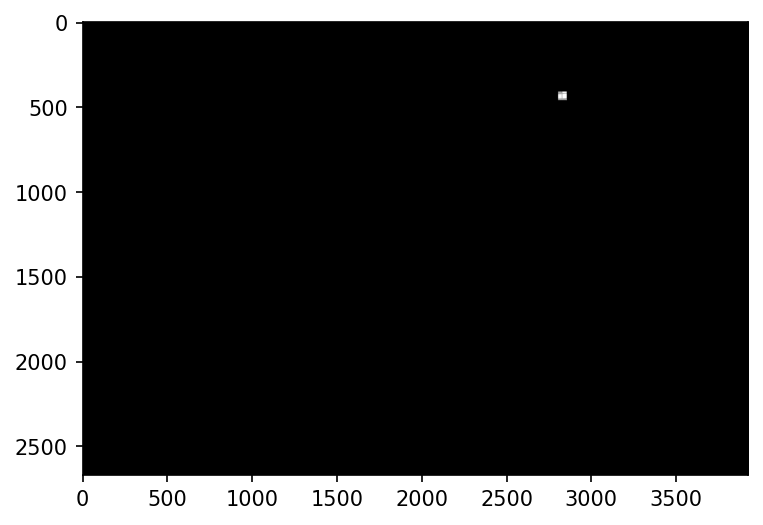

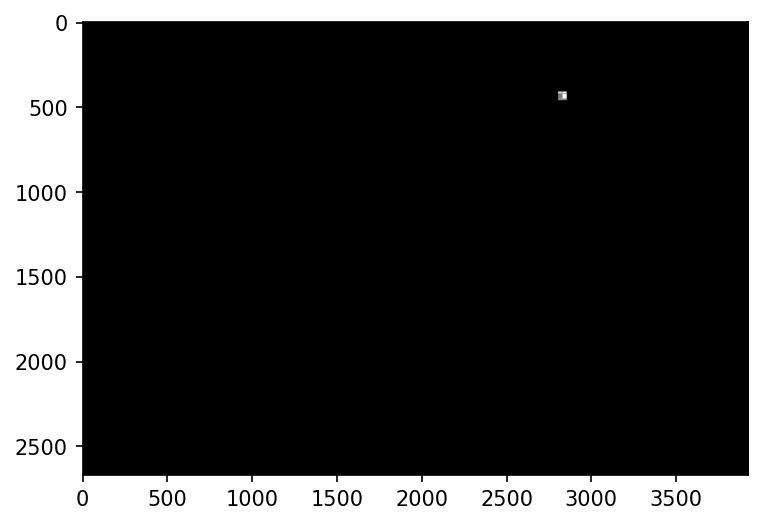

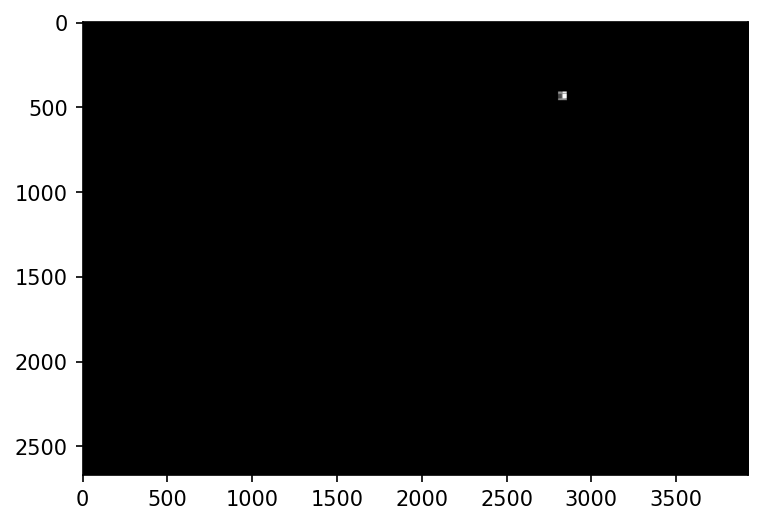

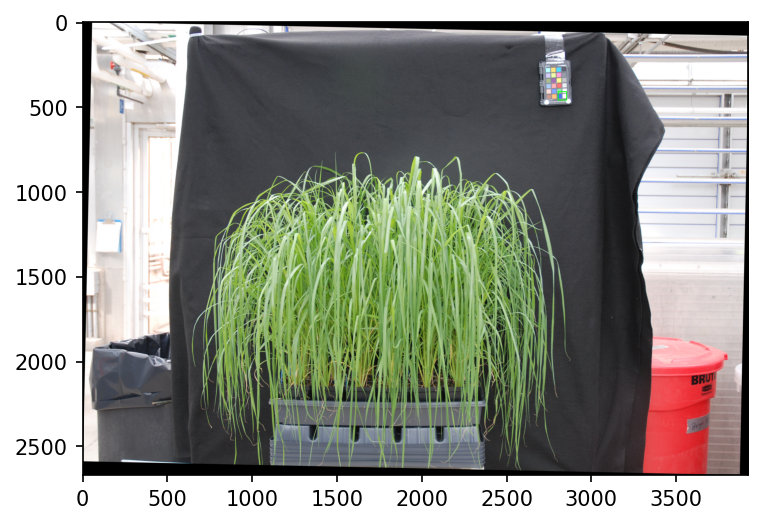

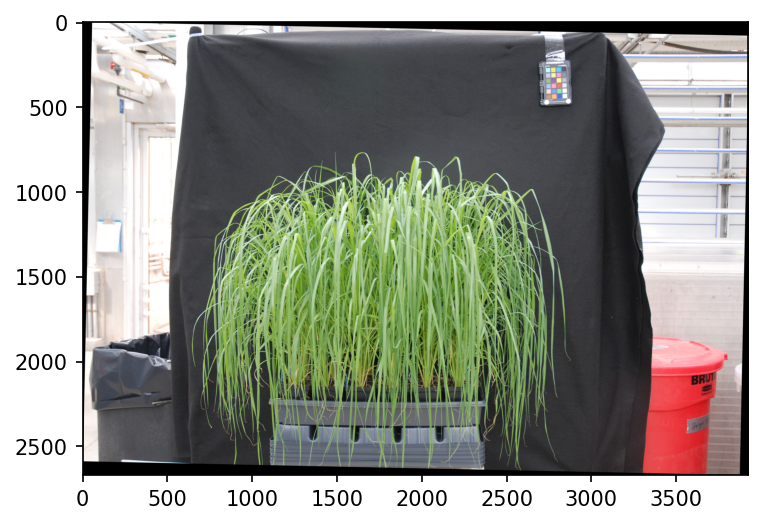

In [64]:
# STEP 2: White balance
try:
    df, start, space = pcv.transform.find_color_card(rgb_img=img)
    img1 = pcv.white_balance(img=img, mode='max', roi=(max(df['x'])-50, max(df['y'])-50, 150, 150))
except:
    img1 = pcv.white_balance(img=img, mode='max', roi=(2800, 410, 50, 50))
#                                                        ^             ^   
#                                                        |_____________|                                       
#                                adjust these these four values, most cases there is no need to change the last two valuse  
#     img1 = pcv.white_balance(img=img, mode='max', roi=(3100, 350, 50, 50))

#### STEP 3: Visualize colorspaces in PlantCV
Visualize the Hue, Saturation, Value (HSV; top row), Lightness, Green-Magenta, Blue-Yellow (LAB; bottom row) colorspaces. We looked for a color channel that enhanced the difference between plant and background. The workshop group decided the Blue-Yellow ("b") channel was the choice.

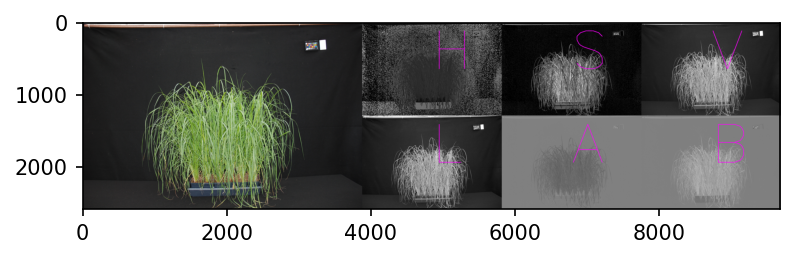

In [20]:
all_cs = pcv.visualize.colorspaces(rgb_img=img1)

#### STEP 4: Convert image from RGB colorspace to LAB colorspace
Extract the Green-Magenta ("a") channel channel from the LAB colorspace.
Other availabilities from LAB colorspace:
lightness ("l")
Blue-Yellow ("b")

<IPython.core.display.Javascript object>


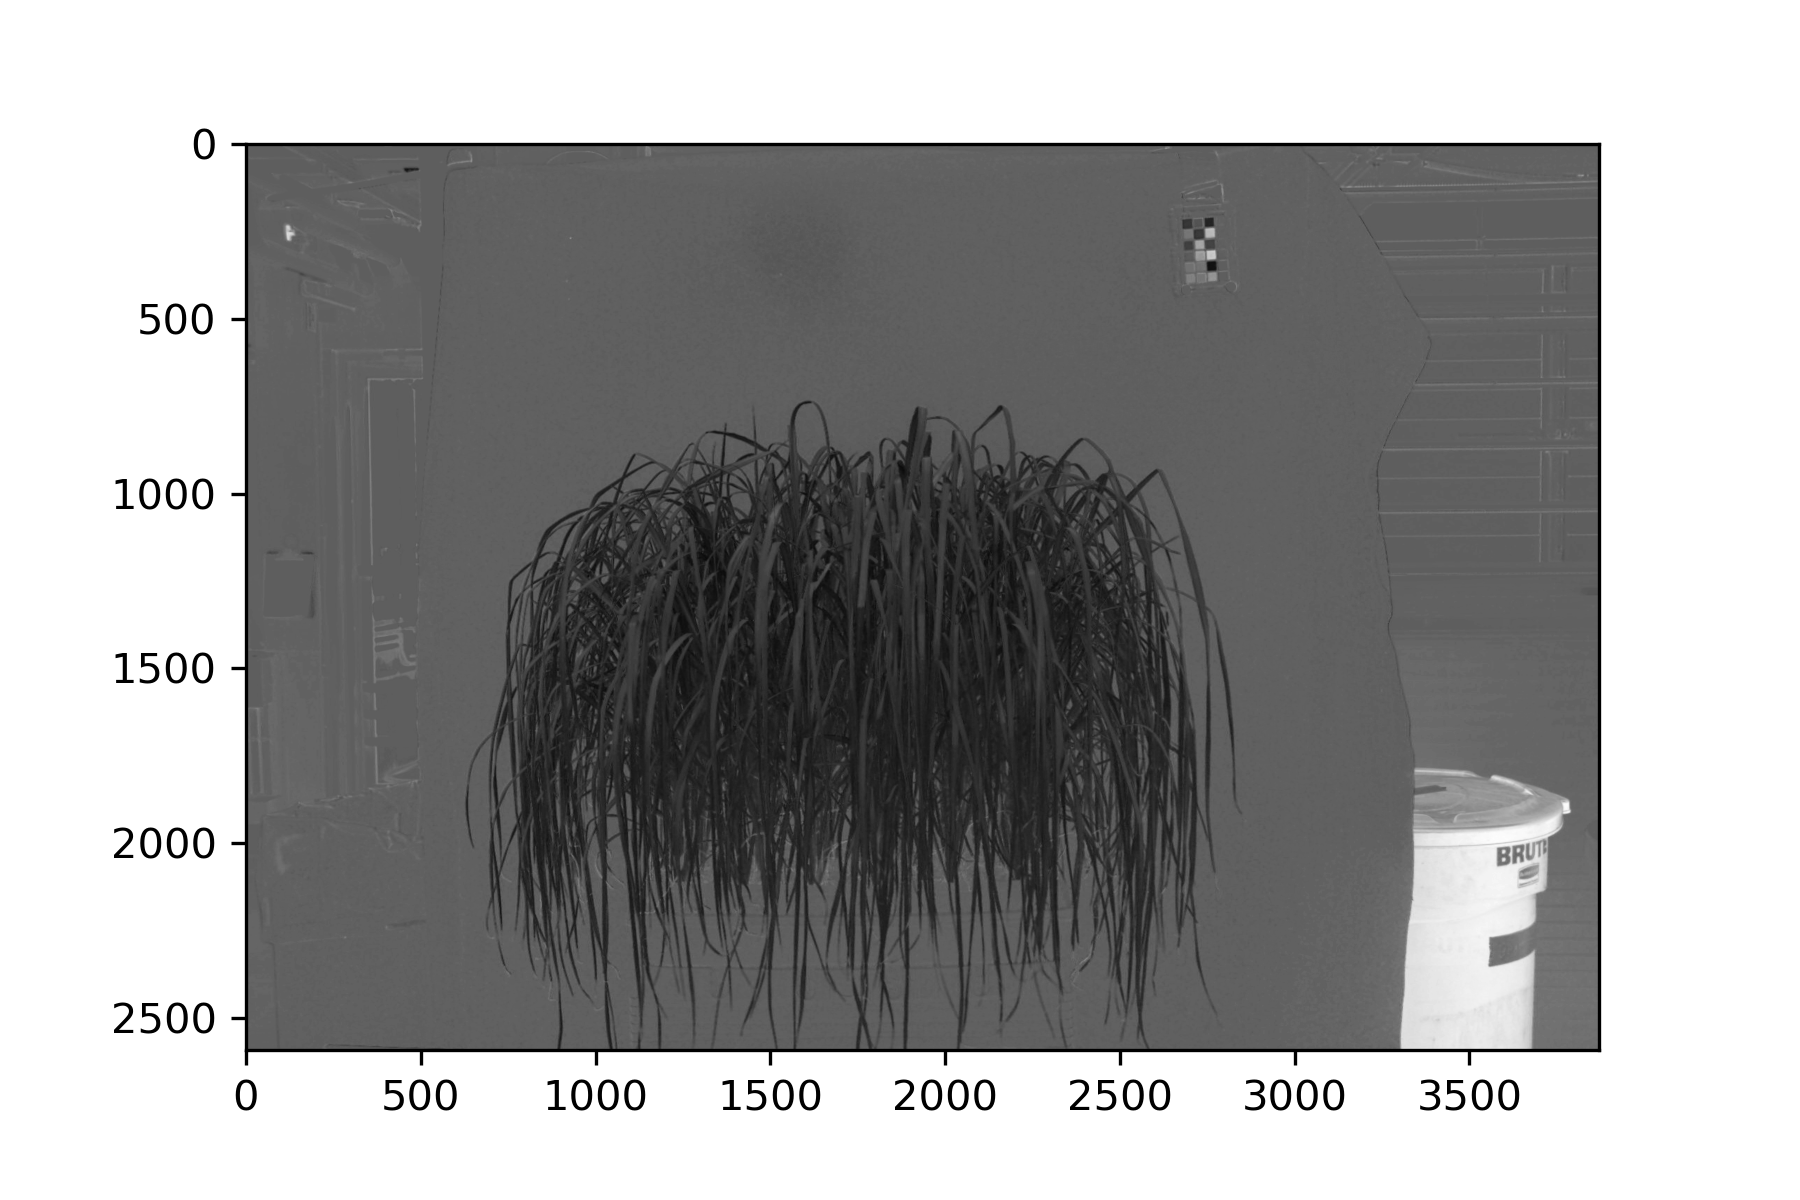

In [49]:
%matplotlib notebook
gray_img = pcv.rgb2gray_lab(rgb_img=img, channel="a")

#### STEP 5: Plot a histogram of pixel values for the selected color channel
Green-Magenta ("a") channel.

<IPython.core.display.Javascript object>


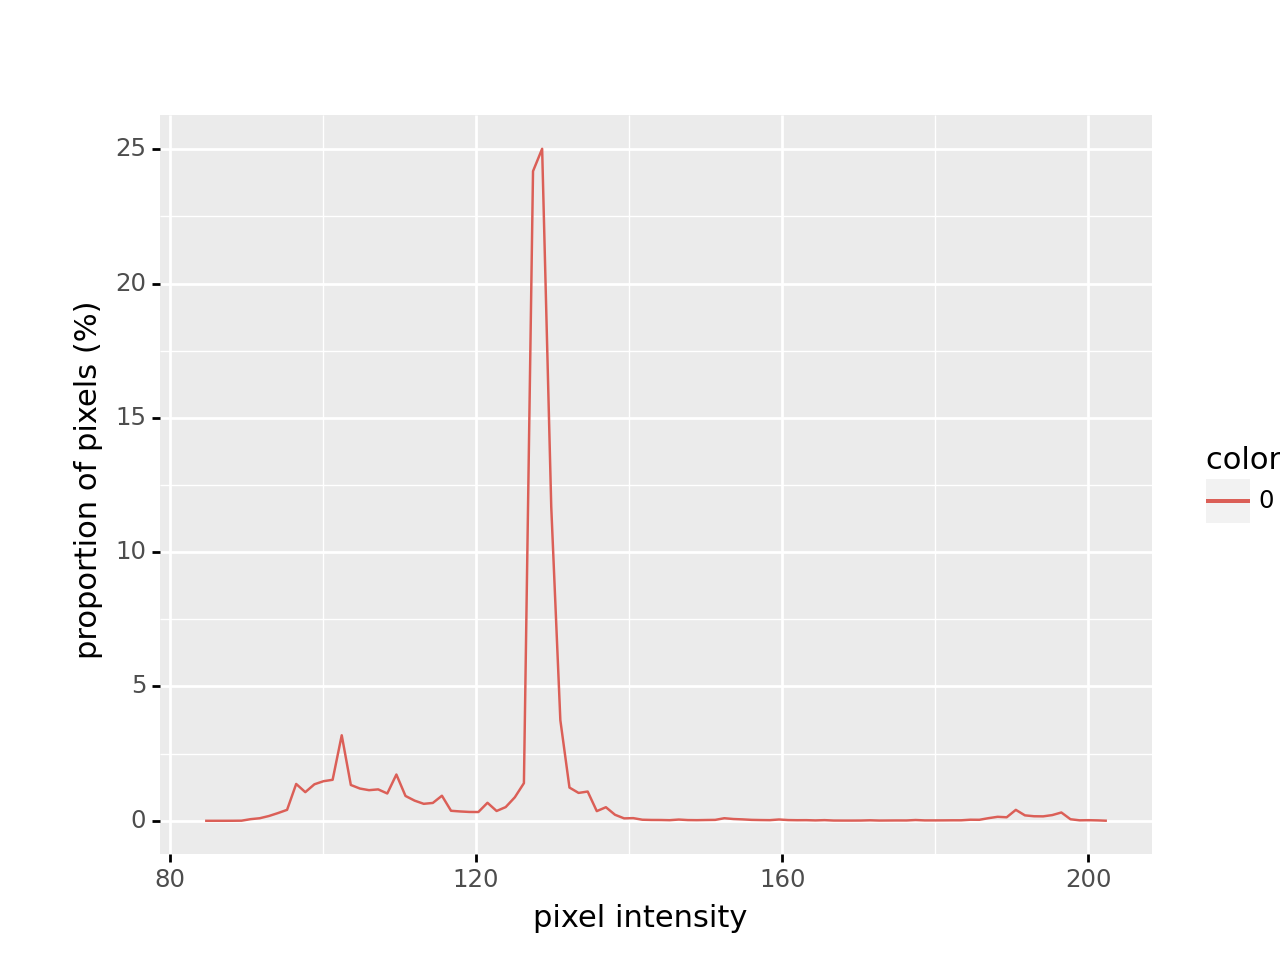

In [50]:
hist_plot = pcv.visualize.histogram(img=gray_img)

#### STEP 6: Apply a binary threshold to the Green-Magenta ("a") channel grayscale image.
In the histogram (in STEP 5) the biggest peak is the uniform background in the image above. 
Through pixel inspection in "notebook" mode (in STEP 4) we saw that the smaller peak between ~110 to 116 are the plant pixels.

This gives us a hint of choosing threshold value. 
We choose a threshold value of 115 to set pixels with values > 115 to black (0) and <= 115 to white (255).

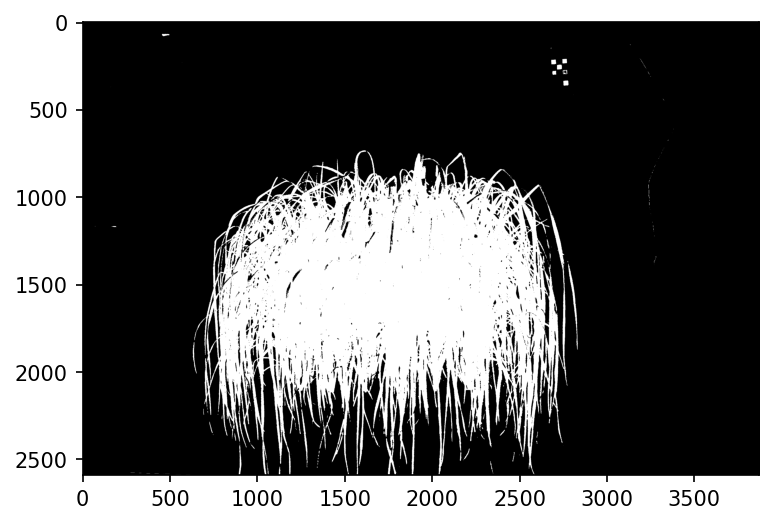

In [51]:
%matplotlib inline
thresh_img = pcv.threshold.binary(gray_img=gray_img, threshold=115, max_value=255, object_type="dark")
#                                                               ^                                 ^
#                                                               |                                 |                 
#                                                       Tune this value       This can be changed to "light" for other types of grayscale images

#### STEP 7: Create a region of interest (ROI)
We have removed most or all of the background around the plant but still have some large background objects (e.g. color card, pot label, etc.). An ROI will allow us to keep objects only in the region we want. Since we know in this dataset that the plants are always centered in the middel of the image we can set an ROI easily. The ROI is centered at 1725, 1155 and has a radius of 400 pixels.

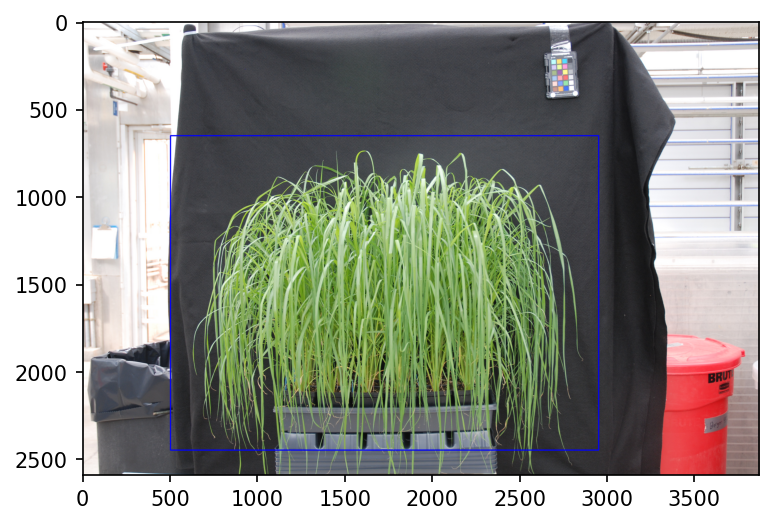

In [52]:
# Create a rectangular ROI
roi, roi_str = pcv.roi.rectangle(img=img, x=500, y=650, h=1800, w=2450)
#                                         ^                     ^   
#                                         |_____________________|   
#                                       
#                                adjust these these four values                    

#### STEP 8: Identify objects in the binary image
Before we can filter out background objects we have to identify objects in the binary image above. The `find_objects` function identifies contours (or connected components) and returns a polygon for each. The `cnts` and `cnts_str` are the list of polygons and the hierarchical relationship between polygons, respectively.

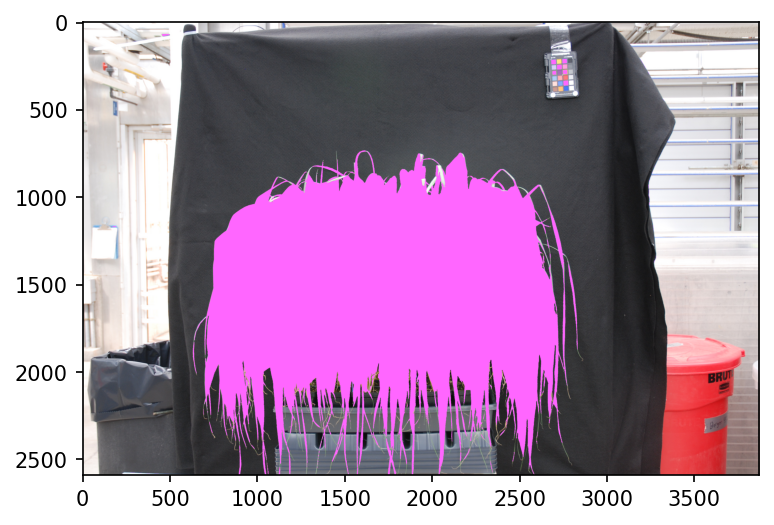

In [53]:
# Identify objects in the binary image
cnts, cnts_str = pcv.find_objects(img=img, mask=thresh_img)

#### STEP 9: Filter objects by a region of interest (ROI)
Now we combine the ROI and polygons found in the previous two steps. The `roi_objects` function will use the ROI to find polygons that overlap and keep them. Polygons completely outside the ROI will be discarded. The polygons need not be entirely enclosed by the ROI, for flexibility, because we are using the mode "partial."

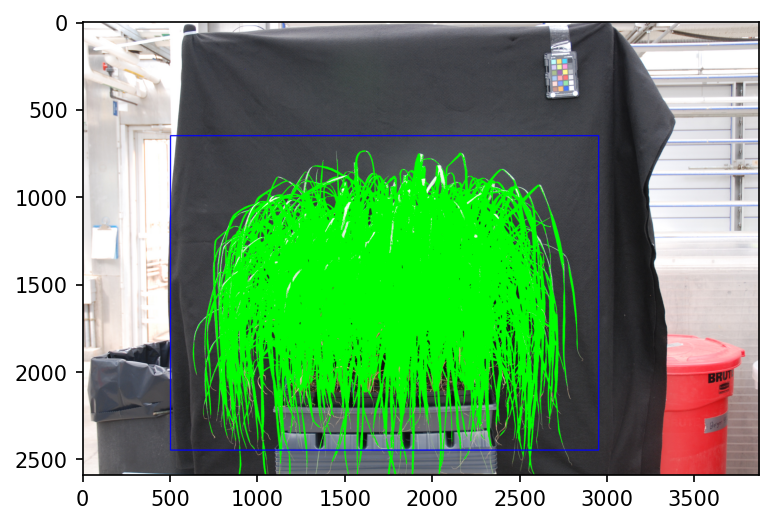

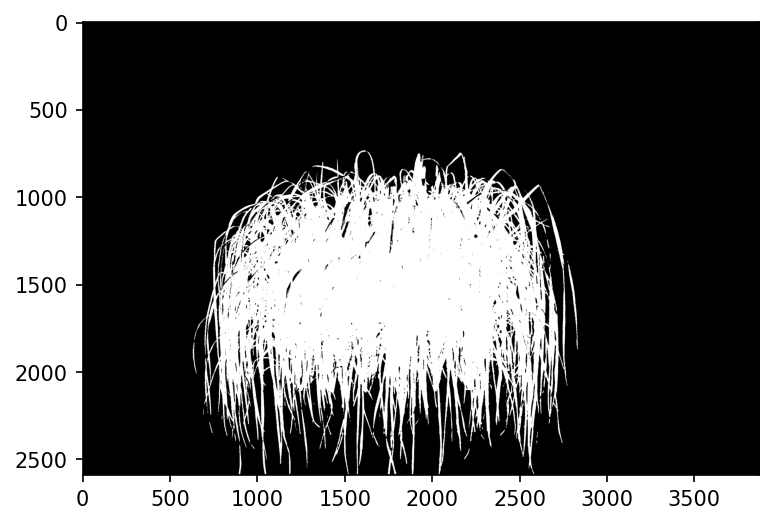

In [54]:
# Filter objects by region of interest
plant_cnt, plant_str, plant_mask, plant_area = pcv.roi_objects(img=img, roi_contour=roi, 
                                                               roi_hierarchy=roi_str,
                                                               object_contour=cnts, 
                                                               obj_hierarchy=cnts_str)

#### STEP 10: Combine remaining objects into a single object
To collect measurements we need to build a single plant object from potentially multiple objects/polygons. For example, sometimes leaves are detected as separate objects.

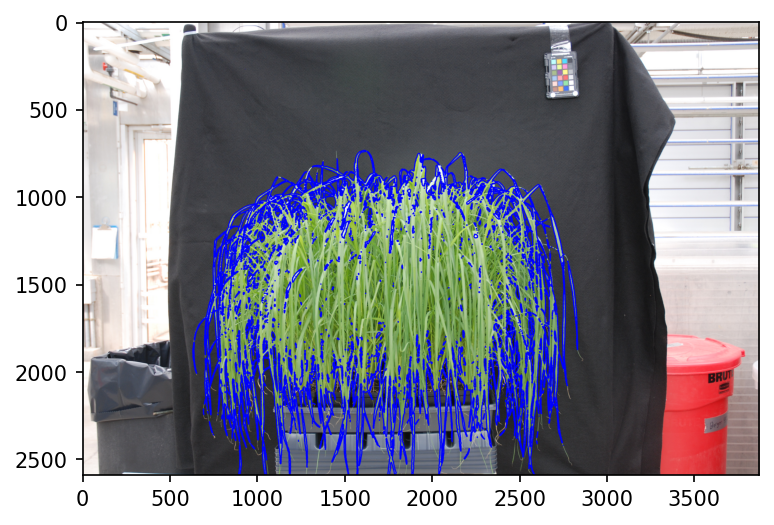

In [55]:
# Combine objects into one
plant, mask = pcv.object_composition(img=img, contours=plant_cnt, hierarchy=plant_str)

#### STEP 11: Measure plant size and shape
The `analyze_object` function outputs measurements about the size and shape of the plant. If the `writeimg` input argument is `True` we will save the output image to a file.

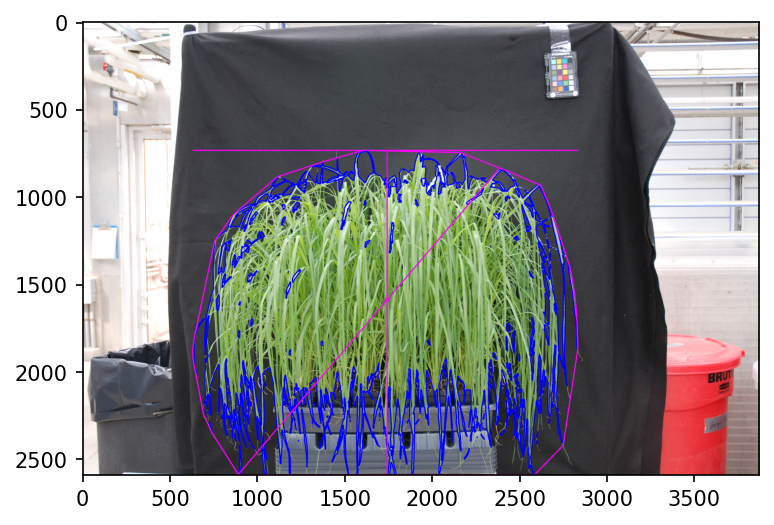

In [56]:
# Measure size and shape properties
shape_img = pcv.analyze_object(img=img, obj=plant, mask=mask)
if args.writeimg:
    pcv.print_image(img=shape_img, filename=os.path.join(args.outdir, "shapes_" + imgname))

#### STEP 12: (Optional) Analyze color of plant
The `analyze_color` function outputs histograms of choice (indicated by `colorspaces`). If the `writeimg` input argument is `True` we will save the output image to a file.

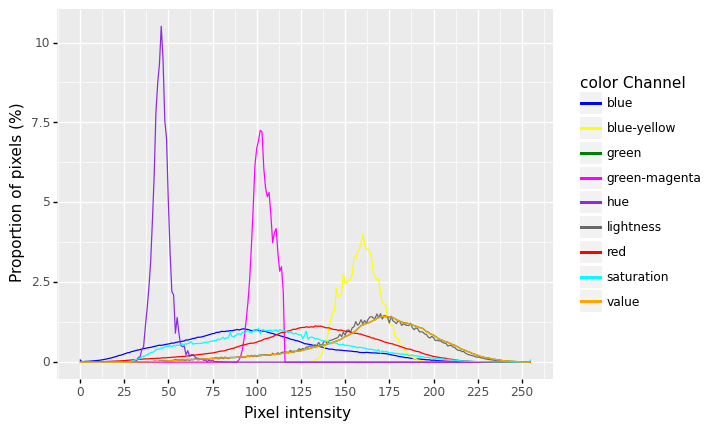

In [58]:
color_img = pcv.analyze_color(rgb_img=img, mask=mask, colorspaces="all")
#                                                           ^                                
#                                                           |                                                 
#                                                     Other choices: "rgb", "lab", "hsv"      
if args.writeimg:
    pcv.print_image(img=color_img, filename=os.path.join(args.outdir, "colors_" + imgname))

#### STEP 13: Set horizontal boundary line
This allows the extraction of biologically meaningful data.

##### STEP 13.1 (Optional) Rotate the image and the mask

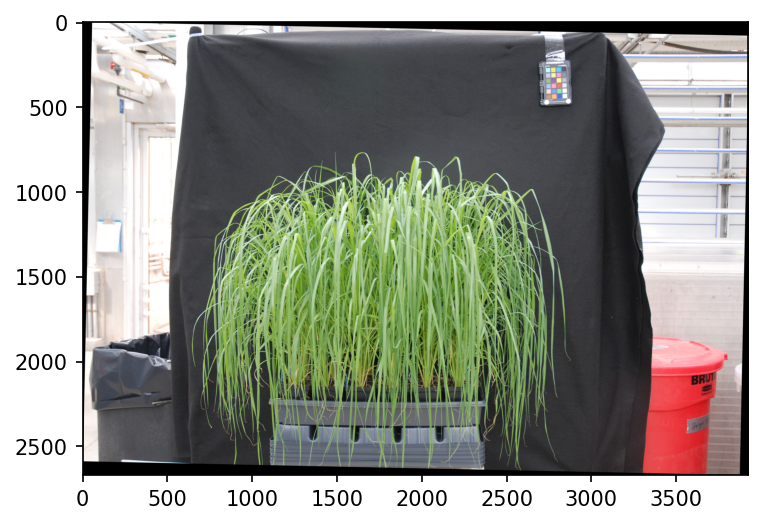

In [59]:
rotate_img = pcv.transform.rotate(img=img, rotation_deg=-1.2, crop=False)
#                                                         ^
#                                                         |
#                                           adjust this value 
#                                          notice that this value can be 
#                                          positive (rotate counter clockwise) or 
#                                          negative (rotate clockwise) 

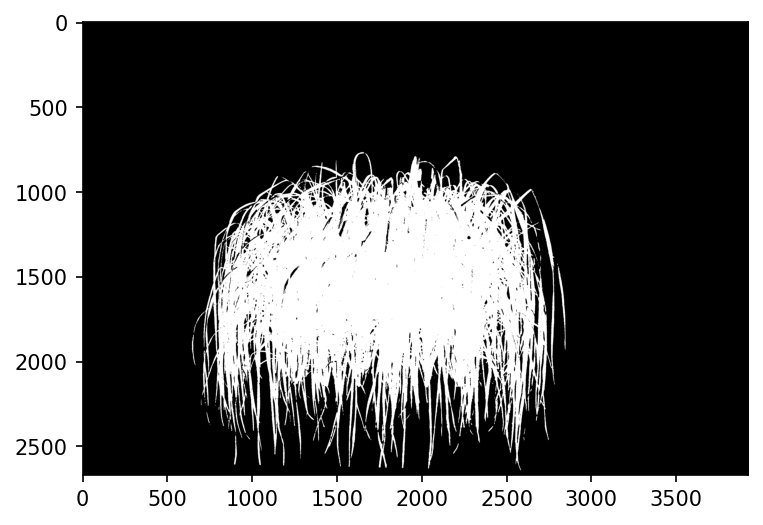

In [60]:
# rotate the mask using the EXACT same value
img  = rotate_img
mask = pcv.transform.rotate(img=mask, rotation_deg=-1.2, crop=False)
#                                                    ^
#                                                    |
#                                           this value should be the EXACT SAME as before

##### STEP 13.2 Set the horizontal reference line to split the measurements into "above line" and "below line"

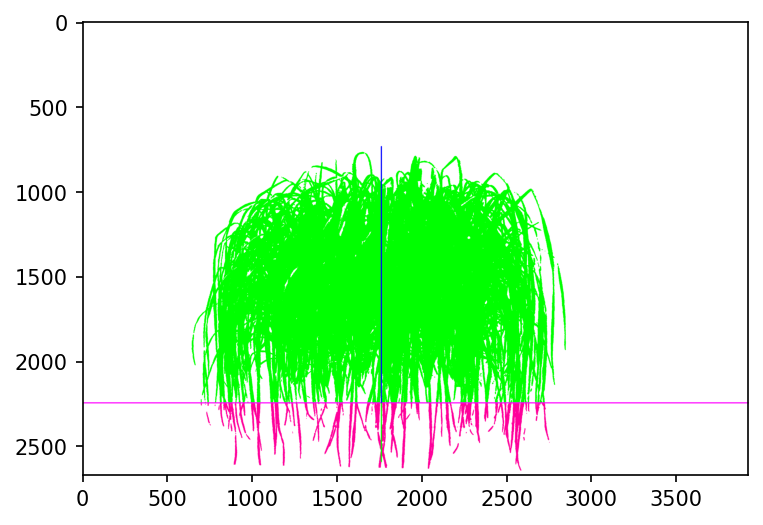

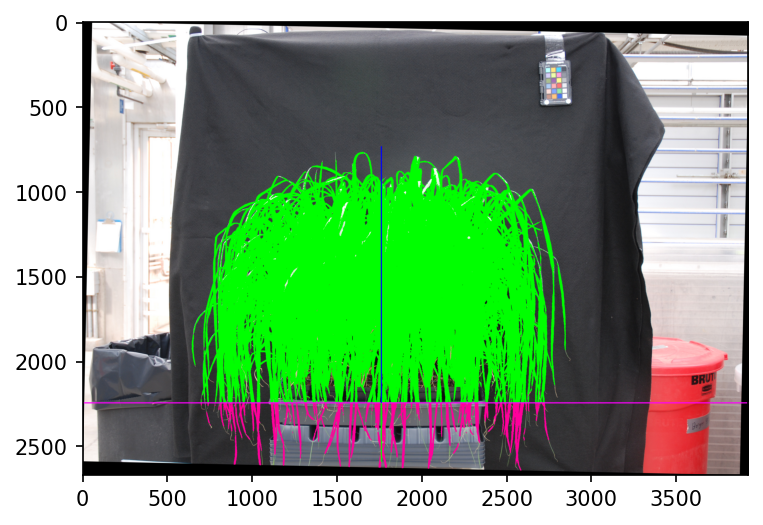

In [61]:
boundary_image = pcv.analyze_bound_horizontal(img=img, obj=plant, mask=mask, line_position=2250, label="default")
#                                                                                            ^
#                                                                                            |
#                                                                                 adjust this value 
if args.writeimg:
    pcv.print_image(img=boundary_image, filename=os.path.join(args.outdir, "bound_" + imgname))

#### STEP 14: Save the measurements to a file
The `save_results` function saves the results collected by all the `analyze_*` functions.

In [62]:
# Save the measurements to a file
pcv.outputs.save_results(filename=args.result, outformat="csv")

#### STEP 15: Try look at some measurements you've collected!
Feel free to take a look at some measurements you've collected, I've included some examples below.

Also take a look to see if your result file is saved!

In [ ]:
# the ratio of area below reference horizontal line to the total area shown in percentage
percent_area_below_reference = pcv.outputs.observations['default']['percent_area_below_reference']['value']

# the ratio of area above reference horizontal line to the total area shown in percentage
percent_area_above_reference = pcv.outputs.observations['default']['percent_area_above_reference']['value']

# the plant height below reference horizontal line 
height_below_reference = pcv.outputs.observations['default']['height_below_reference']['value']

# the plant height above reference horizontal line 
height_above_reference = pcv.outputs.observations['default']['height_above_reference']['value']

# ratio of above reference plant height and below reference plant height
height_ratio = height_above_reference/height_below_reference

# plant width
width = pcv.outputs.observations['default']['width']['value']

# ratio of above reference plant height plant width
height_width_ratio = height_above_reference/width


In [ ]:
print(height_width_ratio)